## Convolutioal Neural Network step by step:
<img src="./images/CNN_01.jpg" style="">
<caption><center><font color="blue"><b>Fig1. Convlutional Neural Network</b></font></center></caption>

In [1]:
# Importing fundamental packages:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# From:
from public_tests import *

# plt.plot settings:
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = "nearest"
plt.rcParams['image.cmap'] = "gray"

<b> `Convolutional` Functions include:</b>
- 1) Zero padding
- 2) Convolve window
- 3) Convolution forward
- 4) Convolution backward

<b> `Pooling` Functions include:</b>
- 1) Pooling forward
- 2) Creating mask
- 3) Distribute value
- 4) Pooling backward

<img src="../CNN_from_scratch/images/model.png" style="width:800px;heigh:300px">

### What is Convolutional Layer ?
- A `convolutional layer` transforms an <b>input volume</b> (or matrix) into an <b>output volume</b> of different size. 

<img src="../CNN_from_scratch/images/conv_nn.png" style="width:400px;height:250px">

In [2]:
# defining zero padding function:
def zero_pad(X, pad):
    """
    pad with zeros all images of the dataset X. The padding is applied to the height and width of an image,
    
    Argumets:
    
    X => python numpy array of shape (m, n_H, n_w, n_C) representing a batch of m images.
    pad => integer, amount of padding around each image on vertical and horizontal dimensions.
    
    Returns:
    X_pad => padded image of shape (m, n_H + 2 * pad, n_w + 2 * pad, n_C)
    
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)))
    
    return X_pad

x.shape:
 (4, 3, 3, 2)
x_pad.shape:
 (4, 9, 9, 2)


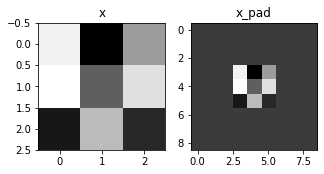

In [3]:
# example:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, pad=3)

# printing results:
print("x.shape:\n", x.shape)
print("x_pad.shape:\n", x_pad.shape)

# figures:
fig, ax_arr = plt.subplots(1, 2)
ax_arr[0].set_title("x")
ax_arr[0].imshow(x[0, :, :, 0])
ax_arr[1].set_title("x_pad")
ax_arr[1].imshow(x_pad[0, :, :, 0])

### 1) Single step of Convolution:

- in this part, we implement a singel step of convolution, in which you we apply the Filter to a single position of the input. This will be used to build a whole convlutional unit, which:

-<b> Takes an input volume </b><br>
-<b> Applies a filter at every position of the input</b><br>
-<b> finally, Outputs another volume (usually of diffetent size)</b><br>

- This GIF shows how this step works:<br>
<img src="../CNN_from_scratch/images/Convolution_schematic.gif" style="width=400px;height=300px">
<caption><center><font color="blue"><b>Fig1: (Convolutional Operation)</b></font></center></caption>

In [4]:
# defining a funciton for one step convolution:
def conv_single_step(a_slice_prev, W, b):
    """
    Applying one filter defined by parameters W on a single slice of (a_slice_prev) of the output
    activaiton of previous layer.
    
    Arguments:
    a_slice_prev => slice of input data of shape (f, f, n_C)
    W => Weight parameters contained in a window, a matrix of shape(f, f, n_C_prev)
    b => Bias parameters contained in a window, a matrix of shape (1, 1, 1)
    
    Returns:
    Z => a scalar value, the result of convolving the sliding window (W,b) on a slice x of input data.
    
    """
    
    s = a_slice_prev * W
    Z = np.sum(s, axis=None)
    Z = Z + float(b)
    
    return Z

In [5]:
# Test of fucntion:
# initializing:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

# using the function:
Z = conv_single_step(a_slice_prev=a_slice_prev, W=W, b=b)
print("Z = ", Z)

# validationg the answers:
assert (type(Z) == np.float32 or type(Z) == np.float64)
assert (np.isclose(Z, -6.999089450680221)), "Wrong Value!"

Z =  -6.999089450680221


In [6]:
# defining Convolutional Forward:
# defining conv_forward:

def conv_forward(A_prev, W, b, hparameters):
    """
    Implementing the forward propagation for a convolution function.
    
    Arguments:
    A_prev => output activation of previous layer => numpy array of shape(m,n_H_prev,n_W_prev,n_C_prerv)
    W => Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b => Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters => python dictionary containing "pad" and "stride".
    
    Return:
    Z => conv_forward output, numpy array of shape (m, n_H, n_W, n_C)
    cache => cache of values needed for conv_backward() function.
    
    """
    # retrieving dimensions:
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # retriving information from hparameters:
    pad = hparameters["pad"]
    stride = hparameters["stride"]
    
    # the output dimension of conv_forward() function:
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1 
    n_W = int((n_W_prev + 2 * pad - f )/ stride) + 1
    
    # initialzing ouput Z with zeros:
    Z = np.zeros(shape=(m, n_H, n_W, n_C))
    
    # creating A_prev_pad using => zero_pad(X, pad)
    A_prev_pad = zero_pad(A_prev, pad)
    
    # looping over the batch of "m" trainng example:
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        
        # looping over the "vertical axis" of the output volume:
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f
            
            # looping over the "horizontal axis" of the output volume:
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                # looping over the channels (= #filters) of the output volume:
                for ch in range(n_C):
                    
                    # using the corners to define (3D) slice of a_prev_pad:
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:, :, :, ch]
                    biases = b[:, :, :, ch]
                    
                    # using conv_single_step() function to output Z:
                    Z[i, h, w, ch] = conv_single_step(a_slice_prev, weights, biases)
                    
    # saving information in "cache" for backprop:
    cache = (A_prev, W, b, hparameters)
    
    # return:
    return Z, cache
                
    

In [7]:
# Test of function:
np.random.seed(1)

A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad":1,
               "stride":2}

Z_output, cache_conv = conv_forward(A_prev, W=W, b=b, hparameters=hparameters)

# print the result:
print(f"Z's mean: {np.mean(Z_output)}")

Z's mean: 0.5511276474566768


### 2) Pooling layer
- The pooling layer (POOL) reduces the heights and width of the input. in fact, it helps to reduce computation, as well as helps make feature detectors more invariant.<br><br>
-<b>There are two main types of `Pooling Layer` :</b><br><br>
1) <b>Max-Pooling layer:</b> slides an (f, f) window over the input and stores the max value of the window in the output.<br>
2) <b>Average_Pooling layer:</b> slides an (f, f) window over the input and stores the average value of the window in the output.<br><br>

<table>
<td>
<img src="../CNN_from_scratch/images/max_pool.png" style="height:300px;width:500px"> 
<td> 
    
<td>
<img src="../CNN_from_scratch/images/max_pool.png" style="height:300px;width:500px">
<td>
    
    
</table>
<caption><center><b><font color="blue"> Max pooling layer </b><center><caption><br>
    
The `Pooling Layers` have no parameters for backpropagation to train.but they have <b>`Hyperparameters`</b> such as the window size $f$.This specifies the `height` and `width` of the $f\times f$ window.

In [8]:
# defining pooling layer function:
# defining pool_forward()

def pool_forward(A_prev, hparameters, mode="max"):
    """
    Implementing the forward pass of the pooling layer.
    
    Arguments:
    A_prev => Input data => numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev).
    hparameters => Python dictionary => containing "f" and "stride".
    mode => The pooling mode, you'd like to use. defined as string => ("max" or "average").
    
    Return:
    A => Output of the pool layer => a numpy array of shape (m, n_H, n_W, n_C)
    cache => cache used in backpropagation, contains the input and hparameters.
    
    """
    
    # retrieving dimensions:
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # retrieving hyper parameters from "hparameters":
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # defining the dimension of the output:
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev
    
    # initializing output matrix "A" with zeros:
    A = np.zeros(shape=(m, n_H, n_W, n_C))
    
    # looping over the batch of "m" training example:
    for i in range(m):
        
        # looping over the "vertical axis" of the output volume:
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f
            
            # looping over the "horizontal axis" of the output volume:
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                # looping over the channels(#filters) of the output volume:
                for ch in range(n_C):
                    a_slice_prev = A_prev[i]
                    
                    if mode == "max":
                        A[i, h, w, ch] = np.max(a_slice_prev[vert_start:vert_end,
                                                             horiz_start:horiz_end, ch])
                    elif mode == "average":
                        A[i, h, w, ch] = np.average(a_slice_prev[vert_start:vert_end,
                                                              horiz_start:horiz_end, ch])
                        
    # saving information in cache for backpropagation:
    cache = (A_prev, hparameters)
    
    return A, cache
                        

In [9]:
# Testing the function:
# Test 1:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride":1, "f":3}

# using the function:
A, cache = pool_forward(A_prev, hparameters=hparameters, mode="max")

print("mode = max")
print(f"A shape: {A.shape}\n")
print(f"A[1, 1]:\n{A[1, 1]}")


mode = max
A shape: (2, 3, 3, 3)

A[1, 1]:
[[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]


In [10]:
# Testing function:
# Test 2:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride":1, "f":3}

# using the funciton:
A, cache = pool_forward(A_prev, hparameters=hparameters, mode="average")
print("mode = average")
print(f"A shape: {A.shape}\n")
print(f"A[1, 1]:\n {A[1, 1]}")

mode = average
A shape: (2, 3, 3, 3)

A[1, 1]:
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]


## The End